# OpenAI Text Generation Model

This will now explore the text generation capabilities of a model you can pay for through API access.

The main goal here is to compare against the open-source models to see if there is a noticeable comparison.

First we need to install all the libraries for openai access.

In [1]:
# install the openai library
%pip install openai

# install token counter
%pip install tiktoken

%pip install evals --quiet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: C:\Users\henry\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: C:\Users\henry\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: C:\Users\henry\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import json
import re
import os
import random
import requests
from collections import defaultdict
import base64
import chardet
import matplotlib.pyplot as plt
# token counting:
import tiktoken

from openai import OpenAI

As before lets load in the data, but this time we need to structure it differently for openai.

In [2]:
def load_and_prepare(file_path):
    """
    Helper function to load in the data into a specific form 

    @PARAMS:
        - file_path -> the file to process
    """
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # format data to be just question-answer pairs
        formatted_data = []
        for entry in data:
            formatted_data.append({
                "question": entry["Question"],
                "response": entry["Answer"]
            })
        
        print(f"Loaded {len(formatted_data)} Q&A pairs from {file_path}!")
        return formatted_data
        
    except Exception as e:
        print(f"Error loading in file...\n{e}")
        return []

In [3]:
# load in formatted data
## TRAIN ##
train_data = load_and_prepare("processed_data/train.json")

## VAL ##
val_data = load_and_prepare("processed_data/validation.json")

## TEST ##
test_data = load_and_prepare("processed_data/test.json")

# print out one value of each to make sure it is loaded correctly
print(train_data[0])
print(val_data[0])
print(test_data[0])

Loaded 18749 Q&A pairs from processed_data/train.json!
Loaded 2344 Q&A pairs from processed_data/validation.json!
Loaded 2344 Q&A pairs from processed_data/test.json!
{'question': 'will eating late evening meals increase my cholesterol?', 'response': 'no. it is what you are eating (as well as your genetics) not when you eat it. it depends on the kinds of foods that you eat. make sure that you are eating healthy foods in order to not gain great amount of cholesterol. you have to always watch what you eat in order to have a healthy skin and body. you may check out www. clearclinic. com for great ideas to achieve an acne free skin.'}
{'question': 'who is affected by arthritis?', 'response': 'arthritis sufferers include men and women children and adults. approximately 350 million people worldwide have arthritis. nearly 40 million people in the united states are affected by arthritis including over a quarter million children! more than 27 million americans have osteoarthritis. approximately

### Generate training data

Needs to be in openai's specific form.

In [ ]:
def generate_training_data(formatted_data):
  """
  Function to generate the Chat-GPT fine-tuning training data.
  @param:
    - formatted_data -> training data specifically formatted for question/response type
  """
  # convert to a df so we can shuffle and preserve randomness
  formatted_data = pd.DataFrame(formatted_data)

  # shuffle
  formatted_data = formatted_data.sample(frac=1).reset_index(drop=True)
  
  # define different contexts to see if it helps the overall model
  system_contexts = [
      "You are a medical expert trained on giving advice to patients that are in need of assistance.",
      "You are an empathetic medical expert here to help with health concerns.",
      "You are a medical expert particularly experienced with interacting with patients and guiding them through their concerns.",
      "You are a medical expert tasked with conversing with patients and helping them discover solutions to their concerns."
  ]

  # write the training file
  with open('processed_data/train.jsonl', 'w') as file:
      for index, value in formatted_data.iterrows():
          # grab the context based on the index
          context = system_contexts[int(index / len(formatted_data) * len(system_contexts))]
          
          line = {
              "messages": [
                  {"role": "system", "content": context},
                  {"role": "user", "content": value["question"]},
                  {"role": "assistant", "content": value["response"]}
              ]
          }

          # write the line to the file
          json.dump(line, file)
          file.write("\n")

In [8]:
# get the training output file
generate_training_data(train_data)

In [ ]:
# load the data into a list of jsons
with open('processed_data/train.jsonl', 'r', encoding='utf-8') as file:
  data = [json.loads(line) for line in file]

# give some basic ouptuts of our training file:
print(f"*Training Data*\nNumber of training values: {len(data)}\nExample Entry:")
for message in data[0]['messages']:
  print(message)

*Training Data*
Number of training values: 18749
Example Entry:
{'role': 'system', 'content': 'You are a medical expert trained on giving advice to patients that are in need of assistance.'}
{'role': 'user', 'content': 'will exercising the vaginal muscles make my vagina tighter?'}
{'role': 'assistant', 'content': "two ultrasound studies of women who exercised their vaginal muscles did find that their muscles were thicker and stronger after pelvic floor muscle training. among women with urine leakage their thinner muscles became the thickness of healthy women's pelvic floor muscles. additionally they had less urine leakage -- whether the problem was from stress or urge types of incontinence. the use of vaginal cones and/or kegel exercises to increase muscle strength were both found to improve tone and decrease urine loss. while some of these studies did not measure vaginal tightness per se when muscle bulk is increased a woman can voluntarily contract those muscles to make the vaginal o

OpenAI is incredibly particular about there being no errors in the training data. Although I just generated it in the required form, I want to build a checking function in case I decide to re-use this on a different form of data.

In [10]:
def check_training_errors(data):
  """
  Function to check the training data is in the right format.
  @param:
    - data -> the list of json training data

  NOTE: for now, this function is redundant since the experiment data is already in the right form, but for the future
  this function might be required to check arbitrary data.
  """
  # create a dictionary with our corresponding errors
  errors = defaultdict(int)
  try:
    # loop through all the training data and count errors
    for line in data[:10]:
      # MAKE SURE EACH LINE IS A DICTIONARY
      if not type(line) is dict:
          errors["data_type"] += 1
          continue
      # split the current value into the messages it contains
      messages = line.get("messages", None)
      # make sure a message exists
      if not messages:
          errors["missing_messages_list"] += 1
          continue
      # loop through the messages in the data point and make sure it belongs to one of the expected groups
      for message in messages:
        # make sure the role and content exists in EACH message
        if "role" not in message or "content" not in message:
            errors["message_missing_key"] += 1
        # make sure the keys are recognized
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            errors["message_unrecognized_key"] += 1
        # make sure the role is recognized
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            errors["unrecognized_role"] += 1

        # get the content and function_call if it exists
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        # make sure there is content in this message
        if (not content and not function_call) or not isinstance(content, str):
            errors["missing_content"] += 1
        # make sure assistant is in any role
        if not any(message.get("role", None) == "assistant" for message in messages):
            errors["example_missing_assistant_message"] += 1
    # if there are errors, output them
    if errors:
        print("Found errors:")
        for key, value in errors.items():
            print(f"{key}: {value}")
    # o/w print no errors
    else:
        print("No errors found")
  # error handling in case of unexpected error occuring in the loop
  except Exception as e:
    print(f"Could not verify data format...\n{e}")

In [19]:
# make sure we have no errors
check_training_errors(data)

No errors found


Now lets get some metrics into the data we will be using as fine-tuning.

In [11]:
def count_tokens(messages, model="gpt-3.5-turbo"):
  """
  Function to count the number of tokens form a set of messages.

  @params:
    - messages -> the strings to count
    - model    -> the Chat-GPT model (default gpt-3.5-turbo)
  """
  # different models have different encodings, lets try and grab the encoding of the input model, if we can't get it, default to cl100k_base
  try:
    encoding = tiktoken.encoding_for_model(model)
  except KeyError as e:
    print(f"Warning: model not found. Using cl100k_base encoding.\n{e}")
    encoding = tiktoken.get_encoding("cl100k_base")

  # default values for tokens:
  tokens_per_message = 3 # from {"role": "system"}, {"role": "user"}, {"role": "assistant"}
  tokens_per_name = 1
  token_count = 0
  # go through each message and update the token count
  for message in messages:
    token_count += tokens_per_message
    # update the token count for the encoding value of the content message
    for key, value in message.items():
      token_count += len(encoding.encode(value))
      if key == "name":
        token_count += tokens_per_name

  # add 3 tokens for the response
  token_count += 3
  return token_count

In [12]:
# lets output the token counts:
n_tokens = []
n_messages = []

# loop through all the training data and get the statistics for the messages
for line in data:
  messages = line['messages']
  n_messages.append(len(messages))
  n_tokens.append(count_tokens(messages))

### OUTPUT STATS
print("Tokens per data point:")
print(f"min, max: {min(n_tokens)}, {max(n_tokens)}")
print(f"mean, median: {np.mean(n_tokens)}, {np.median(n_tokens)}")
print()
print("Messages per data point:")
print(f"min, max: {min(n_messages)}, {max(n_messages)}")
print(f"mean, median: {np.mean(n_messages)}, {np.median(n_messages)}")

Tokens per data point:
min, max: 37, 1576
mean, median: 199.41170195743774, 171.0

Messages per data point:
min, max: 3, 3
mean, median: 3.0, 3.0


Now lets grab the API Key and run the model building!

In [4]:
# read in the .env file
with open("../.env", "r") as f:
    content = f.readlines()

# extract the key from the first line
line = content[0].strip()

# pattern to capture key after '='
pattern = r'API_KEY\s*=\s*(\S+)'

# assign key
match = re.findall(pattern, line)

if match:
    API_KEY = match[0]
else:
    print("API_KEY not found!")

In [5]:
# first connect with the API_KEY we just generated
client = OpenAI(api_key=API_KEY)

Now lets develop a model that can help in viewing the model parameters and details.

In [6]:
class Model:
  """This class defines a Model with customized hyperparameters."""
  def __init__(self, n_epochs=None, learning_rate=None, batch_size=None, temperature=.2):
    """
    Init parameters for a current OpenAI Model can change the epochs, learning rate, and batch size.
    Once trained, you can edit the temperature. For now default it to a deterministic value of .2
    """
    self.n_epochs = n_epochs
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.temperature = temperature
    self.ID = ""
    self.metrics_file = ""

    # create a flag to see if this model is requesting hyperparameter changes:
    if n_epochs or learning_rate or batch_size:
      self.HYPERPARAMETERS = True
    else:
      self.HYPERPARAMETERS = False

  def __str__(self):
    """String representation of the model object"""
    return f"Model ID: {self.ID}\n\nHyperparameters:\n\tEpochs: {self.n_epochs}\n\tLearning Rate: {self.learning_rate}\n\tBatch Size: {self.batch_size}\n"

  def set_ID(self, ID):
    """
    Function to set the OpenAI ID for the given model object.
    @param:
      - ID -> should be the ID of the model for example: ft:gpt-3.5-turbo-0125:nsmbl::9VycFKHK
    """
    self.ID = ID

  def set_metrics_file(self, file):
    """
    Function to set the metrics file name for the given model object.
    @param:
      - file -> should be the resulting file from the training on the model
    """
    self.metrics_file = file

In [7]:
# initialize our baseline model with no hyperparameters
baseline_fine_tuned_model = Model()

In [22]:
# add the training file to the queue
client.files.create(
  file=open("train.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-Mu9JwLAh3jGiHAp6Buy9M35O', bytes=18849223, created_at=1732261149, filename='train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

Now we will run the fine-tuning experiment!!! For this, we will default to the auto parameters OpenAI will give us. The hyperparameters will be in the cell output.

In [23]:
# create the fine-tuning job - hardcoding the file from the output above
client.fine_tuning.jobs.create(
  training_file="file-Mu9JwLAh3jGiHAp6Buy9M35O",
  model="gpt-3.5-turbo",
)

FineTuningJob(id='ftjob-q2v0M5wDwhtPyEYGaMdJk4BI', created_at=1732261193, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mYpLy7xJ1brMrOqq3sMVKxKN', result_files=[], seed=1703914644, status='validating_files', trained_tokens=None, training_file='file-Mu9JwLAh3jGiHAp6Buy9M35O', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

List all fine-tuning jobs.

In [8]:
client.fine_tuning.jobs.list()

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-q2v0M5wDwhtPyEYGaMdJk4BI', created_at=1732261193, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::AWJTxERx', finished_at=1732264748, hyperparameters=Hyperparameters(n_epochs=1, batch_size=12, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mYpLy7xJ1brMrOqq3sMVKxKN', result_files=['file-KdQMELP5ieQxJVxWpUS59hYt'], seed=1703914644, status='succeeded', trained_tokens=3701272, training_file='file-Mu9JwLAh3jGiHAp6Buy9M35O', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)], object='list', has_more=False)

Output info on the baseline and the fine-tuned model.

In [9]:
fine_tuned_model = client.fine_tuning.jobs.retrieve('ftjob-q2v0M5wDwhtPyEYGaMdJk4BI')
baseline_fine_tuned_model.set_ID(fine_tuned_model.fine_tuned_model)
print(fine_tuned_model, "\n")
print(baseline_fine_tuned_model)

FineTuningJob(id='ftjob-q2v0M5wDwhtPyEYGaMdJk4BI', created_at=1732261193, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::AWJTxERx', finished_at=1732264748, hyperparameters=Hyperparameters(n_epochs=1, batch_size=12, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mYpLy7xJ1brMrOqq3sMVKxKN', result_files=['file-KdQMELP5ieQxJVxWpUS59hYt'], seed=1703914644, status='succeeded', trained_tokens=3701272, training_file='file-Mu9JwLAh3jGiHAp6Buy9M35O', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None) 

Model ID: ft:gpt-3.5-turbo-0125:personal::AWJTxERx

Hyperparameters:
	Epochs: None
	Learning Rate: None
	Batch Size: None



Now we need to gather some results from these fine tuned models. Lets compare by taking 100 examples from the test set and building out a text document detailing their responses. This can later be used for evaluation.

In [10]:
# lets run the fine-tuned model against the baseline for the first 100 examples in the test set - doing this to save money!
questions = [point['question'] for point in test_data[:100]]
responses = [point['response'] for point in test_data[:100]]

# write all output to a txt file for later analysis
with open("openai_model_comparison.txt", "w", encoding="utf-8") as f:
    for question, response in zip(questions, responses):
        # setup system config
        system_message = "You are a medical expert helping patients talk through their concerns."
        user_message = question
        
        # fine-tuned response
        fine_tune_completion = client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:personal::AWJTxERx",
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message}
            ]
        )

        # baseline response
        baseline_completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message}
            ]
        )

        # write all to the file!
        f.write(f"Question: {user_message}\n")
        f.write(f"Baseline Model Response: {baseline_completion.choices[0].message.content}\n")
        f.write(f"Fine-tuned Model Response: {fine_tune_completion.choices[0].message.content}\n")
        f.write(f"Expected Response: {response}\n")
        # response seperator
        f.write("=" * 80 + "\n")

Lets grab the metrics file to see how the model tuned!

In [ ]:
# use the requests library to access the fine-tuning metrics file, got the file ID from the output a few cells above
response = requests.get(f'https://api.openai.com/v1/files/file-Mu9JwLAh3jGiHAp6Buy9M35O/content', headers={'Authorization': f'Bearer {API_KEY}'})
if response.status_code == 200:
  content = base64.b64decode(response.content)
  with open("fine-tuning-metrics.csv", "wb") as f:
    f.write(response.content)
else:
  print("Cannot download file...")

We can now visualize these metrics.

In [54]:
def graph_model_metrics(file):
  """
  Function to graph a .csv metrics file retrieved from an OpenAI fine-tuning experiment.
  @param:
    - file - the .csv file converted from the request response in OpenAI
  """
  try:
    # detect encoding
    with open(file, "rb") as f:
      raw_data = f.read()
      result = chardet.detect(raw_data)
      encoding = result["encoding"]
    # convert to dataframe for ease in accesing for matplotlib
    df = pd.read_csv(file, encoding=encoding)
    # loop through all the metrics columns starting after the step column
    for col in df.columns[1:]:
      # only output the columns that have values
      if df[col].isna().any():
        print(f"Skipping metrics graph for {col} as there are null values...")
      else:
        plt.figure(figsize=(10,5))
        plt.plot(df['step'], df[col])
        plt.axhline(y=df[col].mean(), color="red", label="Mean")
        plt.axhline(y=df[col].median(), color="green", label="Median")
        plt.title(col)
        plt.legend()
        plt.show()

  except Exception as e:
    raise Exception(f"Cannot parse metrics file...\n\n{e}")

In [55]:
def get_fine_tune_metrics(client, API_KEY, models):
  """
  Function to analyze metrics off already-trained models.
  @params:
    client  -> established OpenAI API Connection
    API_KEY -> OpenAI api key to connect to the client, needed for the http request
    models  -> list of pre-trained models
  """
  try:
    # loop through the list of models and try to request the metrics file from the previous generalization function
    for index, model in enumerate(models):
      # use the requests library to access the fine-tuning metrics file, got the file ID from the output a few cells above
      response = requests.get(f'https://api.openai.com/v1/files/{model.metrics_file}/content', headers={'Authorization': f'Bearer {API_KEY}'})
      if response.status_code == 200:
        content = base64.b64decode(response.content)
        # generate the .csv file data for each of the models
        with open(f"fine-tuning-metrics={model.metrics_file}.csv", "wb") as f:
          f.write(content)
        f.close()
        print(f"Metric output for model:\n{str(model)}\n\n")
        # now graph the outputs
        graph_model_metrics(f"fine-tuning-metrics={model.metrics_file}.csv")
        # add spacing
        print()
      else:
        print(f"Cannot download file: {model.metrics_file}...")
  except Exception as e:
    raise(f"Cannot parse metrics...\n\n{e}")

Metric output for model:
Model ID: ft:gpt-3.5-turbo-0125:personal::AWJTxERx

Hyperparameters:
	Epochs: None
	Learning Rate: None
	Batch Size: None





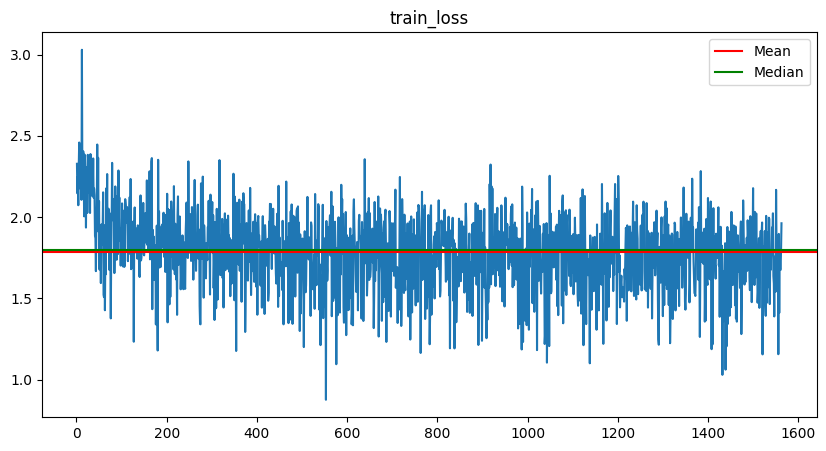

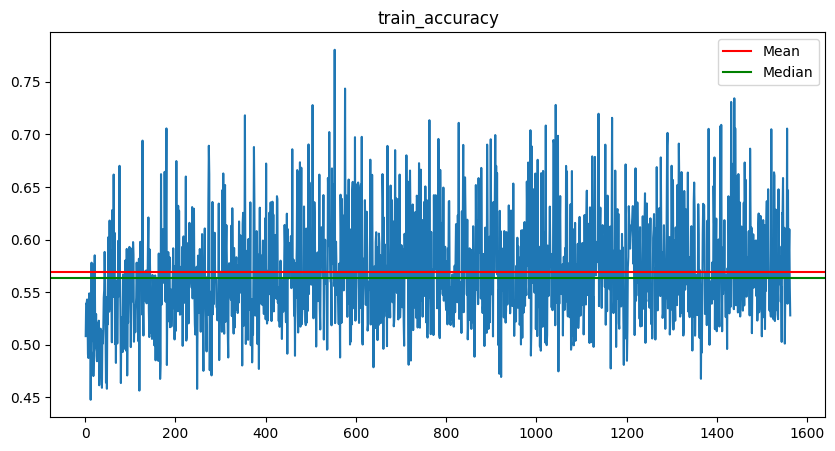

Skipping metrics graph for valid_loss as there are null values...
Skipping metrics graph for valid_mean_token_accuracy as there are null values...



In [56]:
baseline_fine_tuned_model.set_metrics_file("file-KdQMELP5ieQxJVxWpUS59hYt")
get_fine_tune_metrics(client, API_KEY, [baseline_fine_tuned_model])

### Future Use

This function below runs an experiment of fine-tuning multiple models with the same dataset, where you can specify specific hyperparameters. Due to this just being a class project, I will stick to the model with the parameters OpenAI default picked for me to save money, but for future use, I will come back to this!

In [ ]:
def fine_tune(client, models, data, openAI_model):
  """
  Function to fine-tune a list of models based on their desired hyperparameters.
  @params:
    client       -> established OpenAI API Connection
    models       -> list of models generated with specific hyperparameters
    data         -> the data to train each model on
    openAI_model -> desired OpenAI model to re-train

  NOTE: currently, this function only works for training each model on the same dataset.
  """
  try:
    # before the training, queue the data for training:
    ID = client.files.create(
      file=open(data, "rb"),
      purpose="fine-tune"
    ).id
    # create a dictionary with the parameter values for each model to make sure we are not training the same model twice
    model_parameters = {i:"" for i in range(len(models))}
    # perform the same api call for each model:
    for index, model in enumerate(models):
      # add to the dictionary the model parameters if it doesn't already exist
      params = f"n_epochs: {model.n_epochs}, learning_rate: {model.learning_rate}, batch_size:{model.batch_size}"
      # make sure this model has NOT been fine-tuned already, if so skip it
      if params not in model_parameters.values():
        model_parameters[index] = params
        # if the hyperparameters were specified, note in the client call
        if model.HYPERPARAMETERS:
          # grab only the ones that are not None
          hyperparameters = {}
          if model.n_epochs:
            hyperparameters["n_epochs"] = model.n_epochs
          if model.learning_rate:
            hyperparameters["learning_rate"] = model.learning_rate
          if model.batch_size:
            hyperparameters["batch_size"] = model.batch_size

          model_ID = client.fine_tuning.jobs.create(
            training_file=ID,
            model=openAI_model,
            hyperparameters=hyperparameters
          ).id
        # if no hyperparemeters were requested, let OpenAI pick them
        else:
          model_ID = client.fine_tuning.jobs.create(
            training_file=ID,
            model=openAI_model,
          ).id

        # finally update the metrics file for this model
        model.set_metrics_file(client.fine_tuning.jobs.retrieve(model_ID).id)
    # output the current fine-tuning jobs, once this function completes access to the specified models is applicable
    print(client.fine_tuning.jobs.list())
    # for now, return the model parameters
    return model_parameters
  except Exception as e:
    print(f"Error, could not fine-tune on input parameters...\n{e}")


Example of how to call the fine-tune job, even with just one model.

In [ ]:
m = Model(n_epochs=3)
fine_tune(client, [m], "train.jsonl", "gpt-3.5-turbo")